# Домашнее задание 2

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)
pio.renderers.default = "notebook_connected"

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import STL

from sktime.forecasting.all import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.compose import DirectTimeSeriesRegressionForecaster
from sktime.forecasting.ets import AutoETS
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

import datetime
from tqdm import tqdm
from scipy.stats import norm, chi2 

В этом домашнем задании мы поупражняемся с ETS-моделью и STL-разложением. Сначала коротко про данные.

Представьте себе стандартный банкомат, который работает только на выдачу. Его нужно периодически пополнять наличностью, чтобы он функционировал непрерывно. Однако выезд инкассаторов является делом хлопотным и недешёвым, так что хотелось бы не гонять их лишний раз заполнять наполовину полный банкомат. Хотелось бы научиться предсказывать спрос людей на наличность в банкомате, чтобы можно было предсказывать время, когда количество денег в банкомате снизится до минимально допустимой величины. Этим мы и займёмся. Для простоты возьмём один конкретный банкомат. Нам доступны объёмы выдачи в банкомате по дням.

##### 1) Загрузка данных и визуальный анализ (1 балл)

Загрузите данные из файла atm.csv. Рекомендуется для нормальной работы некоторых фукнций перевести индекс в тип PeriodIndex. Например, можно создать date_range с нужной частотой. Изобразите временной ряд, его автокорреляции и частные автокорреляции. Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность?

In [2]:
atm = pd.read_csv('atm.csv', parse_dates=[0], index_col=0)
atm = atm.resample('D').sum()
#atm.index = atm.index.to_period('D')

- Тренда не наблюдается. 

- Относительно пиковых значений можно выделить цикличность: пополнение банкомата крупными суммами происходит в определенные даты каждого месяца (например, каждый год 21 октября, 20 ноября и т. д.) Однако промежутки между этими датами не фиксированы, так что это не сезонность.

In [3]:
fig = px.line(
    atm, 
    x=atm.index, 
    y='target',
    title='Наш временной ряд ❤️'
    )
fig.show()

Построим ACF и PACF ряда:

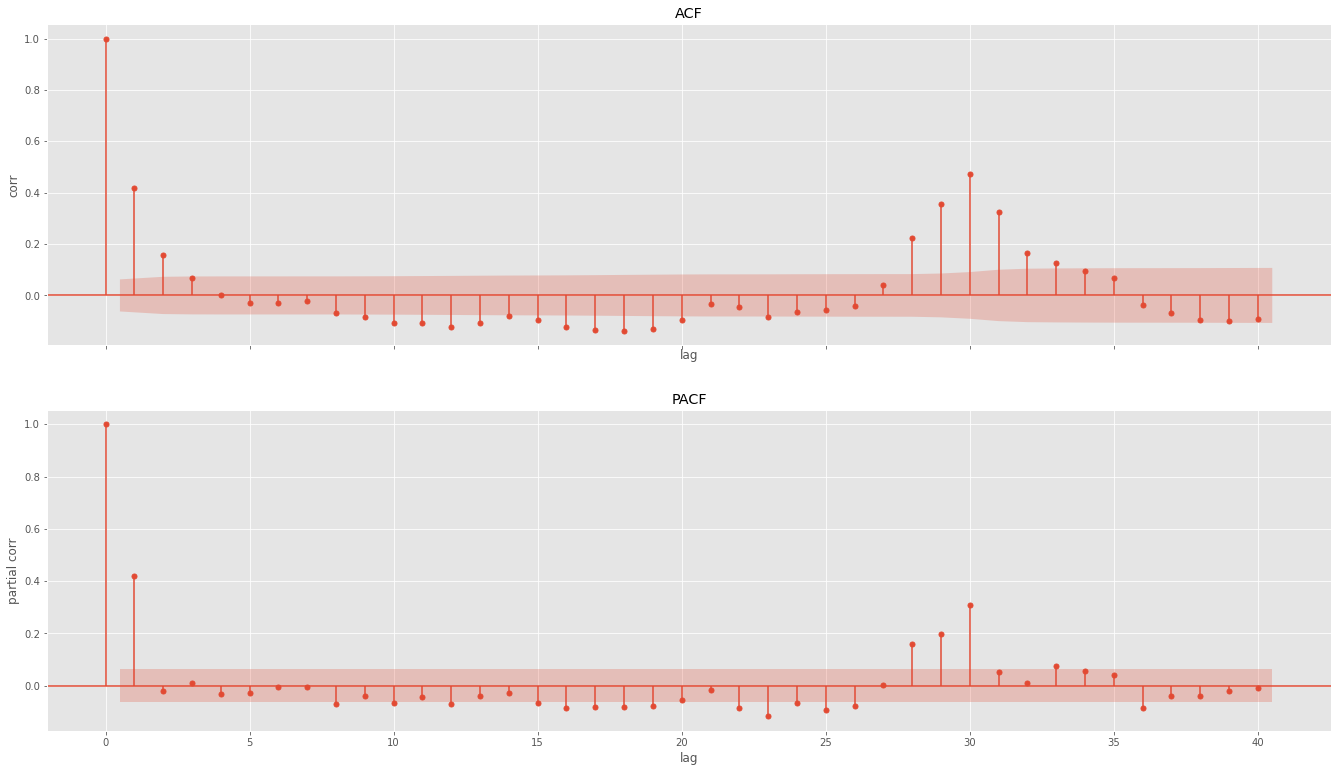

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(23, 13), sharex=True)
plot = plot_acf(atm['target'], ax=ax[0], lags=40)
plot = plot_pacf(atm['target'], ax=ax[1], lags=40)
ax[0].set(title='ACF', xlabel='lag', ylabel='corr')
ax[1].set(title='PACF', xlabel='lag', ylabel='partial corr')
plt.show()

##### 2) Предобработка данных (0.5 балла)

Разбейте данные на трейн и тест. Размер теста: последние 30 дней.

Как легко заметить, данные неотрицательны. Но давайте на случай использования мультипликативных ETS-моделей их децентрируем. К тренировочной части прибавьте произвольную небольшую константу (например 100 рублей). Обратите внимание, что константу придётся вычесть из прогнозов итоговой модели при подсчёте метрик относительно теста.

Дополнительно можете произвести обратимые преобразования, которые сочтёте необходимыми.

In [5]:
atm += 120
y_train, y_test = temporal_train_test_split(atm, test_size=30)

## Покомпонентное прогнозирование

В данном разделе мы попробуем пофильтровать ряд с помощью двух моделей: STL-разложения и ETS-модели.

### Блок 1. STL

##### Разложение (0.3 балла)

Начнём с STL. Примените на трейне STL-разложение. В качестве параметра period возьмите самый сильный лаг автокорреляций. Визуализируйте отдельные компоненты.

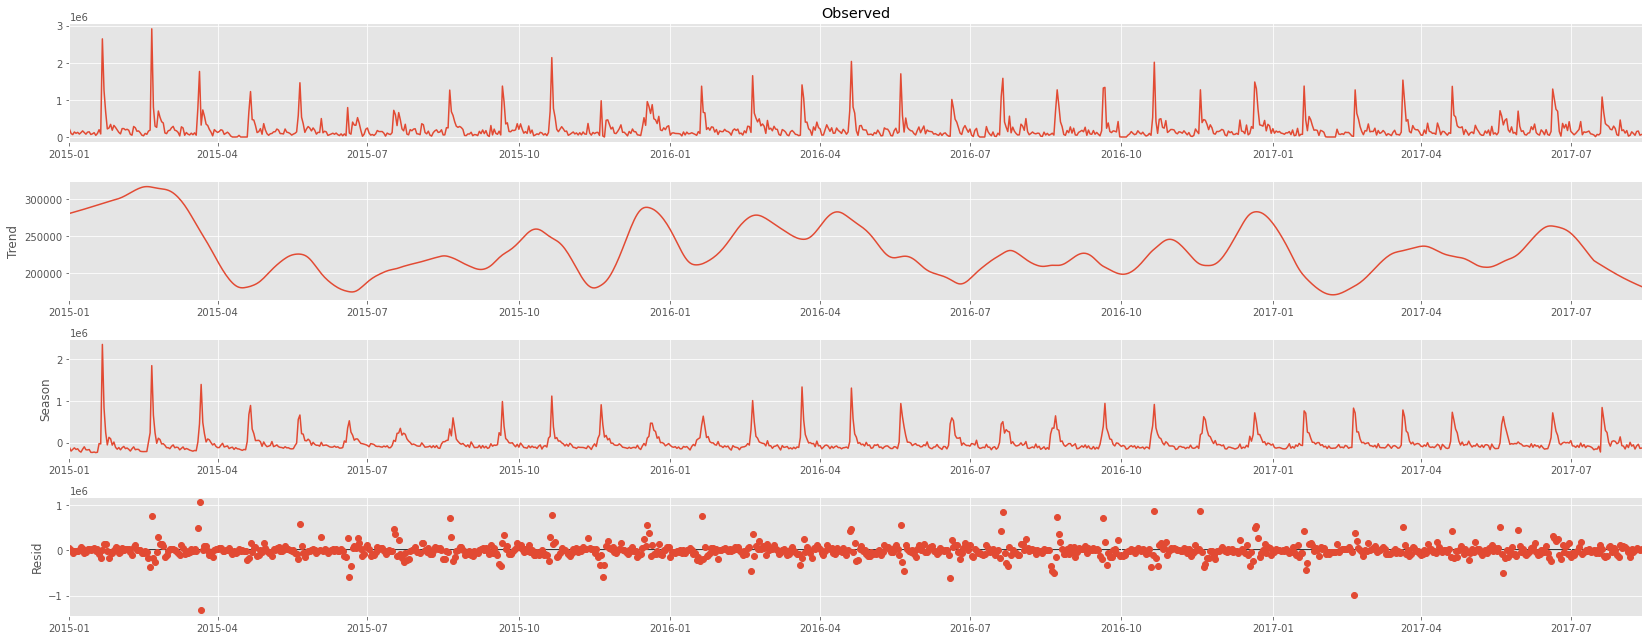

In [6]:
stl = STL(y_train, period=30)
res = stl.fit()

res.plot()
plt.show()

##### Прогнозирование отдельных компонент (0.6 балла)

Возьмём выделенные из STL компоненты. Постройте какие-нибудь простые модели (без фичей) для тренда и сезонности.

Например, для тренда можно взять модель полиномального тренда из sktime. Для сезонности можно использовать NaiveForecaster с указанием периодичности. Спрогнозируйте каждую компоненту 30 шагов (по 0.3 за каждую компоненту).

*Возьмем те модели, что рекомендованы выше :)))*

In [7]:
def forecast_component(comp, estimator, **kwargs):
    est = estimator(**kwargs)
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    est = est.fit(comp, fh=fh)
    out = est.predict()

    return out

stl_trend_seas_fc = forecast_component(res.trend, PolynomialTrendForecaster, **{'degree' : 10}) + forecast_component(res.seasonal, NaiveForecaster, **{'sp' : 30})

#### Прогнозирование остатков. 

##### Подготовка данных (0.9 балла)

Достанем временной ряд остатков из STL-разложения. Построим отдельную модель с остатками STL в качестве таргета и потом сложим с прогнозами отдельных компонент из предыдущего шага. Получим этакий бутерброд. Прогнозируем отдельно на 30 шагов каждую компоненту: тренд, сезонность и ошибку, а потом суммируем прогнозы.

Многошаговый прогноз остатков потребует уже модели с фичами. По сути эта задача эквивалентна многошаговому прогнозированию из ДЗ-1. В этот раз вам не будет дано конкретных указаний по генерации переменных. Но будет выдана дополнительная информация о банкомате. Можете её использовать, можете нет, на ваше усмотрение.

Расположение: ул Крымский Вал, 9стр45

Дополнительная информация: ГАУК культуры города Москвы ЦПКиО им. М.Горького

Широта: 55.73259

Долгота: 37.600891

Также в помощь прилагается файл с различными календарными фичами (events.csv), чтобы не повторять в этой домашке то же самое, что в прошлой. Можете использовать любые фичи из этого файла, но для засчитывания пункта необходимо придумать минимум три фичи (по 0.3 за каждую), не входящие в приложенный файл. Каждую используемую фичу (не важно, из файла или придуманную вами) необходимо кратко обосновать. Не забывайте учитывать потенциальные утечки. За их наличие балл также может быть снижен.

Результатом пункта должны быть вектор y_train и матрица X_train для модели остатков.

В качестве кастомных фич возьмем календарные, чтобы они были известны заранее. С учетом имплементации моделей многошагового прогнозирования средствами `sktime` это не особо существенно.

- Особые дни (дни, по которым банкомат пополняют большой суммой денег)
- Дни, следующие за особыми (следующий и через один). В эти дни поведение тоже выделяется.
- Квартал, чтобы попробовать уловить странную динамику пиков.

Замечу, что я также формирую фичи для теста, поскольку все они календарные и известны заранее. 

In [8]:
exog = pd.read_csv('events.csv', parse_dates=[0], index_col=0)

X_train = exog[['выходной', 'праздник', 'короткий рабочий день']]
X_train = X_train.resample('D').sum()

atm_aux  = atm.head(atm.shape[0] - 30)
# Первая фича: особенный день
X_train['special_day'] = X_train.index.to_series().dt.day.isin(
    (atm_aux[atm_aux.target > 1e6].index.to_series().dt.day.astype(str) + '_' + atm_aux[atm_aux.target > 1e6].index.to_series().dt.month.astype(str)).unique()
).astype(int)

# Вторая фича: следующий особенный день
X_train['special_day_1'] = X_train.index.to_series().dt.day.isin(
    ((atm_aux[atm_aux.target > 1e6].index.to_series().dt.day + 1).astype(str) + '_' + atm_aux[atm_aux.target > 1e6].index.to_series().dt.month.astype(str)).unique()
).astype(int)

# Третья фича: следующий-следующий особенный день
X_train['special_day_2'] = X_train.index.to_series().dt.day.isin(
    ((atm_aux[atm_aux.target > 1e6].index.to_series().dt.day + 2).astype(str) + '_' + atm_aux[atm_aux.target > 1e6].index.to_series().dt.month.astype(str)).unique()
).astype(int)

# Четвертая фича: квартал
X_train['quarter'] = X_train.index.to_series().dt.quarter



X_test = X_train.loc[y_test.index, :]
X_train = X_train.loc[y_train.index, :]



resid = res.resid

#### Кросс-валидация

Теперь займёмся подбором оптимальной модели остатков STL на трейне. Для этого используем кросс-валидацию.

##### Реализация метода (0.6 балла)

Так как нас интересуют именно многошаговые прогнозы, стандартная кросс-валидация нам не подойдёт. Выберите любой из двух методов кросс-валидации временных рядов (скользящее или расширяющееся окно) на ваше усмотрение.

 Реализуйте класс, который будет по входным параметрам окна выдавать индексы всех фолдов. По поведению можно ориентироваться на знакомый вам k-fold. Хорошей практикой будет возвращать в методе split генератор, хотя это и не обязательно. На каждом фолде модель будет обучаться на трейне и делать многошаговый прогноз на тест. Позаботьтесь о том, чтобы ширина окна была соотнесена в логичной пропорции с горизонтом прогнозирования. Ширина окна 35 при горизонте 30 -- сомнительная практика.


In [9]:
class CustomCrossVal: # расширяющееся окно
    def __init__(self, window_size = 300, step=30):

        '''Args:
            window_size (int): The size of window. For expanding window -- initial size of window
            step (int): Window step. For expanding window is a growth of window. For sliding window is number of obs to slide.
        '''

        self.window_size = window_size
        self.step = step

        if (window_size // 2) < step:
            print('Осторожно: изначальное окно слишком мало для выбранного горизонта прогнозирования!')

    def split(self, X):
        '''Args:
            X (pandas DataFrame): Dataframe to split.
        '''
        n_obs = X.shape[0]
        border = self.window_size + self.step

        while border <= n_obs:
            train = np.arange(0, border - self.step)
            test = np.arange(border - self.step, border)
            yield train, test

            border += self.step

##### Отбор моделей (0.5 балла)

Выберите 3-4 модели-кандидата и отберите с помощью реализованной вами кросс-валидации наилучшую. Можно использовать разные модели либо разные наборы фичей. Метрика: MAE.

In [10]:
mae = MeanAbsoluteError()

In [11]:
def resid_forecast(y, X_train, X_test, estimator, **kwargs):
    fh = ForecastingHorizon(X_test.index, is_relative=False)
    est = estimator(**kwargs)
    forecaster = make_reduction(est, window_length=1, strategy="direct")
    forecaster.fit(y, X=X_train, fh=fh)
    out = forecaster.predict(X=X_test)

    return out


Кандидатов выберем по дефолту: линейную регрессию, случайный лес и KNN.

In [12]:
candidates = [
    (LinearRegression, dict()),
    (RandomForestRegressor, {'n_estimators' : 10}),
    (KNeighborsRegressor, {'n_neighbors' : 10})
]

Поехали!

In [13]:
cv_mae = []

for candidate in candidates:
    model, model_params = candidate
    model_name = type(model()).__name__
    print(f'Evaluating CV for {model_name}...')

    cand_mae = []
    i = 1
    for tridx, tsidx in CustomCrossVal().split(X_train):
        real = resid.iloc[tsidx]
        pred = resid_forecast(resid.iloc[tridx], X_train.iloc[tridx,:], X_train.iloc[tsidx,:], model, **model_params)
        error = mae(real, pred)
        cand_mae.append(error)

        if (i < 4) or (i > 20):
            print(f'\tfold {i} OK')
        elif i == 4:
            print('\t...')
        else:
            pass
        i+= 1

    cand_mae = np.mean(cand_mae)
    cv_mae.append([model_name, cand_mae])

Evaluating CV for LinearRegression...
	fold 1 OK
	fold 2 OK
	fold 3 OK
	...
	fold 21 OK
Evaluating CV for RandomForestRegressor...
	fold 1 OK
	fold 2 OK
	fold 3 OK
	...
	fold 21 OK
Evaluating CV for KNeighborsRegressor...
	fold 1 OK
	fold 2 OK
	fold 3 OK
	...
	fold 21 OK


Лучшая модель &mdash; линейная регрессия:

In [14]:
cv_mae

[['LinearRegression', 95341.34857754907],
 ['RandomForestRegressor', 122761.3119927831],
 ['KNeighborsRegressor', 105340.84182027579]]

##### Прогноз моделей (0.5 балла)

Обучите наилучшую модель на всём трейне и постройте прогноз на тестовый период. Используйте любую из многошаговых стратегий, но прямая будет самым простым решением. 

In [15]:
resid_fc = resid_forecast(resid, X_train, X_test, LinearRegression)

##### Бэктестинг (1 балл)

Обучив наилучшую модель на трейне, вычтите из y_train тренд и сезонность (полученные из STL), а также прогноз вашей модели остатков на трейн. Таким образом вы получите остатки вашей совокупной модели на трейне. Нарисуйте графики автокорреляций этих остатков. Есть ли в каких-то интересных датах значимые пики? Как думаете, с чем эти ошибки модели связаны? (0.5 балла)

Реализуйте тест Ljung-Box. Протестируйте остатки на наличие серийных автокорреляций при нескольких m. $\alpha = 0.05$. (0.5 балла)

Если гипотеза отвергается, можете попытаться улучшить модель и поискать фичи по графикам автокорреляций, но это опционально. В ряде ситуаций становится сложно построить модель, в которой гипотеза не отвергается, поэтому иногда на наличие автокорреляций закрывают глаза.

In [16]:
# Чтобы получить insample предсказания (и остатки), будем использовать что-то довольно кривое.

aux_X = np.hstack([pd.DataFrame(resid.shift(i)) for i in range(1, 3)] + [X_train.shift(i) for i in range(0, 2)]) # вроде получилось сделать что-то похожее на первую модель прямой стратегии
aux_X = pd.DataFrame(aux_X).fillna(0) # вообще все фичи мы знаем довольно точно, но мне лень заполнять :)
pseudo_resid = LinearRegression().fit(X=aux_X, y=resid).predict(aux_X)
pseudo_resid = pd.Series(pseudo_resid, index=y_train.index, name='pseudo')

In [17]:
resid_overall = y_train['target'] - res.trend - res.seasonal - pseudo_resid

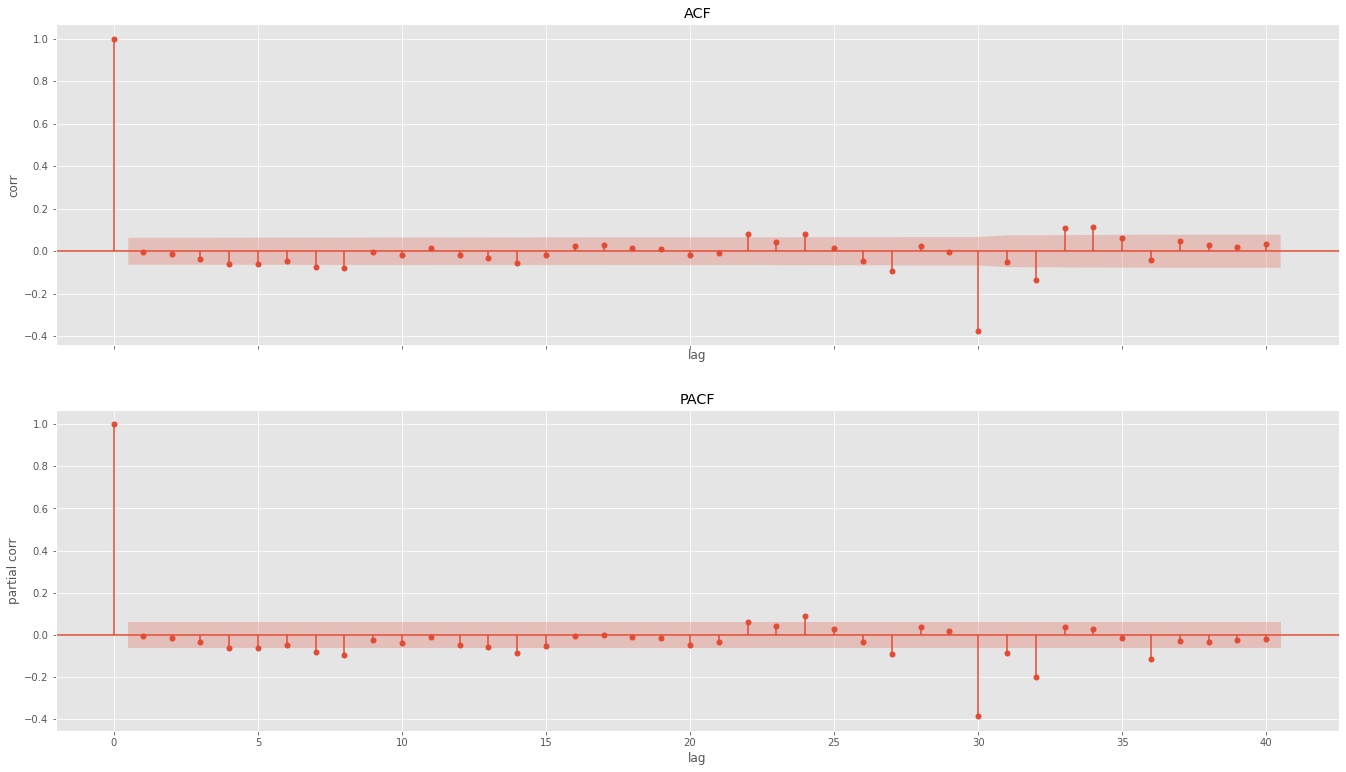

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(23, 13), sharex=True)
plot = plot_acf(resid_overall, ax=ax[0], lags=40)
plot = plot_pacf(resid_overall, ax=ax[1], lags=40)
ax[0].set(title='ACF', xlabel='lag', ylabel='corr')
ax[1].set(title='PACF', xlabel='lag', ylabel='partial corr')
plt.show()

In [19]:
def ljung_box(y, m):
    n_obs = y.shape[0]
    corrs = [np.corrcoef(y[k:], y.shift(k)[k:])[0][1] for k in range(1, m+1)]

    denominator = np.arange(1, m+1)
    test_stat = np.sum(np.square(corrs) / (n_obs-denominator)) * n_obs * (n_obs + 2)

    return 1-chi2.cdf(test_stat, 10)

In [20]:
for m in [2, 5, 10, 20, 30]:
    lb_p = ljung_box(resid_overall, m)
    conclusion = 'H0 rejected' if (lb_p<0.05) else 'H0 not rejected'
    if m == 2:
        output = f'Ljung-Box p-value (m={m}): {np.round(lb_p, 3)},\t' + conclusion
    else:
        output = f'                ↳ (m={m}): {np.round(lb_p, 3)},\t' + conclusion

    print(output)

Ljung-Box p-value (m=2): 1.0,	H0 not rejected
                ↳ (m=5): 0.578,	H0 not rejected
                ↳ (m=10): 0.016,	H0 rejected
                ↳ (m=20): 0.001,	H0 rejected
                ↳ (m=30): 0.0,	H0 rejected


Гипотеза отвергается :(

Бонус! (0.5 балла)

Реализуйте тест Бройша-Годфри. Описание можно почерпнуть из [Википедии](https://en.wikipedia.org/wiki/Breusch–Godfrey_test). Протестируйте остатки на наличие автокорелляций. Изменился ли результат?

In [21]:
# ༼ つ ◕_◕ ༽つ

##### Результаты и визуализация (0.6 балла)

Соберите в сумму прогнозы всех компонент STL-разложения. Не забудьте на сумму прогнозов компонент применить преобразования, обратные тем, которые были сделаны на трейне.  Визуализируйте прогноз и тестовые данные. Подсчитайте MAE прогноза. Подсчитайте MAE сезонного наивного прогноза (на каждой точке теста -- последнее наблюдение за аналогичный день в предыдущем месяце, 30 дней назад). Справилась ли ваша модель лучше? **(лучше чем что ахах)**

In [22]:
stl_trend_seas_resid_fc = stl_trend_seas_fc + resid_fc - 120

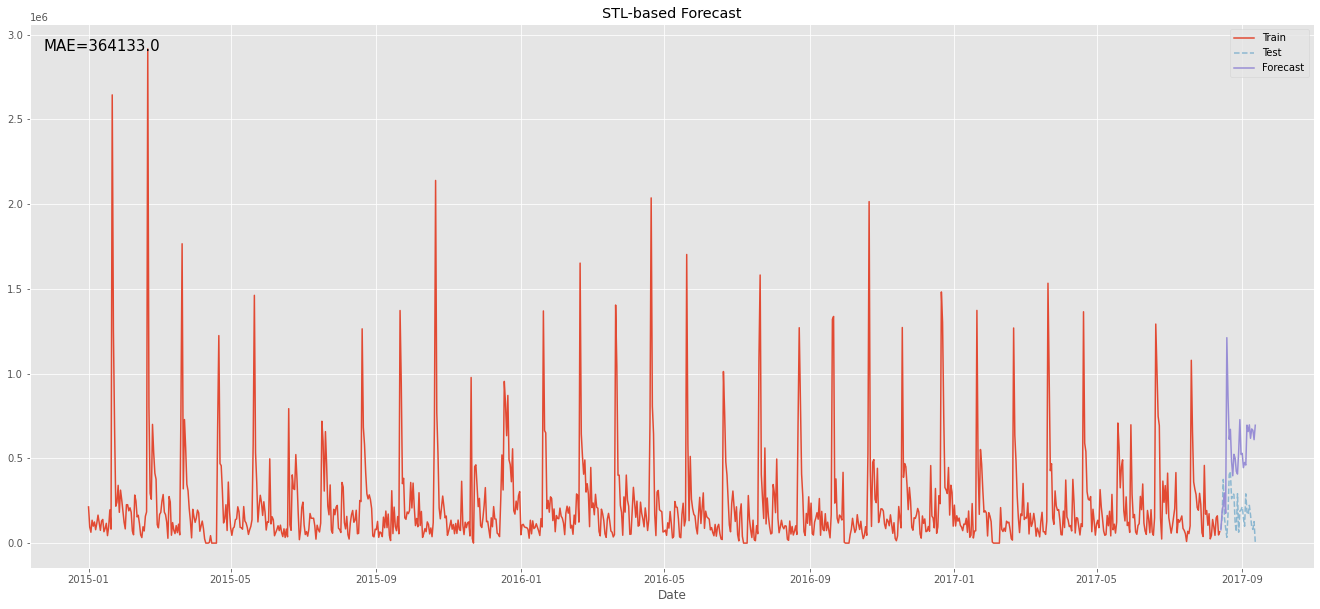

In [23]:
fig, ax = plt.subplots(1, figsize=(23, 10))

ax.plot(y_train - 120, label = 'Train')
ax.plot(y_test - 120, label = 'Test', alpha=.5, ls='--')
ax.plot(stl_trend_seas_resid_fc, label = 'Forecast')

curr_mae = np.round(mae(y_test - 120, stl_trend_seas_resid_fc))
ax.text(0.01, 0.95, f'MAE={curr_mae}', size=15, transform=ax.transAxes)

ax.set(title='STL-based Forecast', xlabel='Date', ylabel='')
ax.legend()
plt.show()

Не оч вышло :(

### Блок 2. ETS-модель

Теперь повторим то же самое, только моделировать тренд и сезонность будем одновременно одной ETS-моделью, а на остатки ETS-модели навешивать вторую модель.

##### Визуальный анализ (1 балл)

Вернитесь к y_train. Взгляните на ряд и опишите, какие из вариантов ETS-модели подошли бы под наши данные. Сформируйте сетку параметров для моделей-кандидатов. Кратко поясните каждую опцию, которую вы включаете в сетку, основываясь на визуальном анализе.

Несколько замечаний:
- Несмотря на то, что наш ряд выглядит скорее цикличным, нежели сезонным, нам все равно хотелось бы улавливать сезонность. При этом вряд ли нам понадобится мультипликативная версия, ведь роста дисперсии сезонных колебаний не наблюдается.
- Тренд у нас отсутствует. Поэтому делаем ставку на модель без тренда, но на всякий случай проверим также и модель с аддитивным трендом.
- Чтобы не волноваться лишний раз, проверим оба варианта спецификации ошибки. Ведь наш ряд строго положительный!

##### Кросс-валидация (0.3 балла)

С помощью кросс-валидации выберите наилучшую по MAE ETS-модель. Обучите её на всём трейне и спрогнозируйте на тест. 

In [24]:
seasonal = ['add']
trend = ['add', None]
error = ['add', 'mul']

candidates = []

for e in error:
    for t in trend:
        for s in seasonal:
            spec = [e, t, s]
            candidates.append(spec)

In [25]:
cv_mae = []
warnings.filterwarnings("ignore")

for candidate in candidates:
    e, t, s = candidate
    e_n = 'A' if e == 'add' else 'M'
    t_n = 'A' if t == 'add' else 'N'
    s_n = 'A'
    print(f'Evaluating CV for ETS({e_n}{t_n}{s_n})...')
    model_name = f'ETS({e_n}{t_n}{s_n})'
    cand_mae = []
    i = 1

    # сразу уберем нестабильные модели
    if f'{e_n}{t_n}{s_n}' in [
        'MMA',
        'ANM',
        'AAM',
        'AMN',
        'AMA',
        'AMM'
        ]:
        continue

    for tridx, tsidx in CustomCrossVal().split(X_train):
        real = y_train.iloc[tsidx]

        ets = AutoETS(error=e, trend=t, seasonal=s, sp=30)
        ets.fit(y_train.iloc[tridx])
        fh = ForecastingHorizon(real.index, is_relative=False)
        pred = ets.predict(fh=fh)

        error = mae(real-120, pred-120)
        cand_mae.append(error)

    cand_mae = np.mean(cand_mae)
    cv_mae.append([model_name, cand_mae])

cv_mae = pd.DataFrame(cv_mae, columns=['Model', 'MAE']).sort_values('MAE', ascending=True)

Evaluating CV for ETS(AAA)...
Evaluating CV for ETS(ANA)...
Evaluating CV for ETS(MAA)...
Evaluating CV for ETS(MNA)...


Как видим, лучшей моделью оказался ETS без тренда, с сезонностью, и с аддитивными ошибками:

In [26]:
cv_mae # отсортировано по возрастанию MAE :)

,Model,MAE
1,ETS(ANA),150519.214443
0,ETS(AAA),153215.887254
3,ETS(MNA),272800.049569
2,ETS(MAA),433429.033774


In [27]:
ets_best = AutoETS(seasonal='add', sp=30)
ets_best.fit(y_train)
fh = ForecastingHorizon(X_test.index, is_relative=False)

ets_trend_seas_fc = ets_best.predict(fh=fh)

##### Подготовка данных (0.1 балла)

Достаньте остатки ETS-модели на трейне. Они будут использованы в качестве таргета для второй модели. Можно использовать те же фичи, что и в разделе про STL, без дополнительных пояснений. Результатом пункта должны быть вектор y_train и матрица X_train для модели остатков.

<AxesSubplot:>

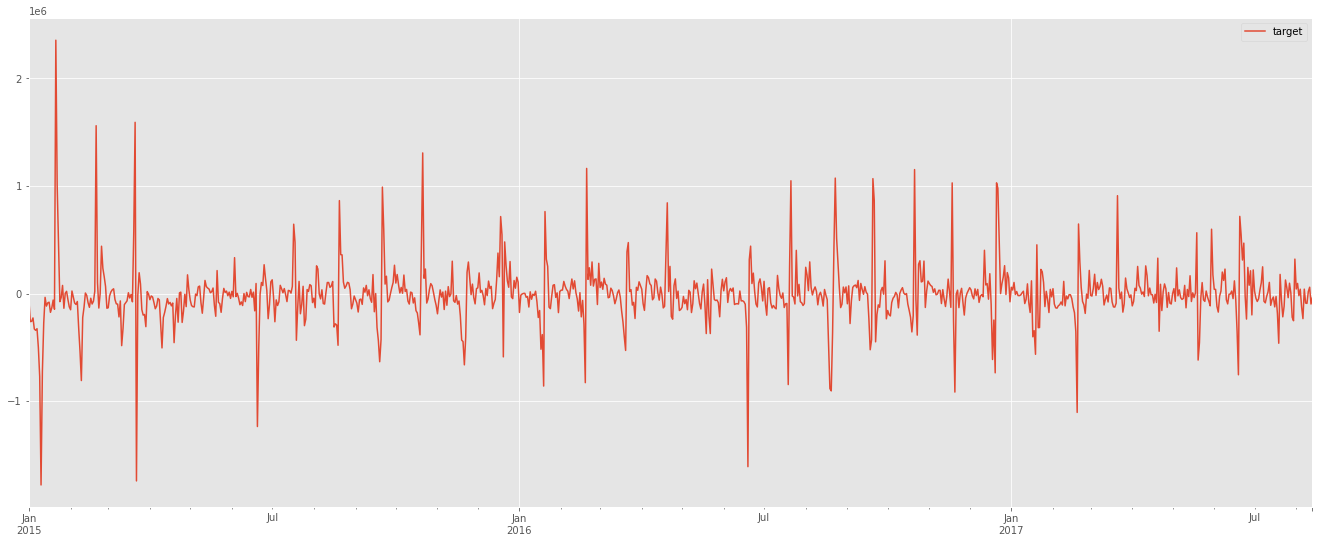

In [28]:
resid_ets = ets_best.predict_residuals(y=y_train)
resid_ets.plot()

##### Отбор моделей остатков и кросс-валидация (0.5 баллов)

Отберите 3-4 модели-кандидата для прогнозирования остатков и отберите на кросс-валидации наилучшую по MAE модель. Размер валидации на каждом фолде всё также равен 30, как длина теста. Используйте реализованный ранее класс для кросс-валидации. 

In [29]:
candidates = [
    (LinearRegression, dict()),
    (RandomForestRegressor, {'n_estimators' : 10}),
    (KNeighborsRegressor, {'n_neighbors' : 10})
]

In [30]:
cv_mae = []

for candidate in candidates:
    model, model_params = candidate
    model_name = type(model()).__name__
    print(f'Evaluating CV for {model_name}...')

    cand_mae = []
    i = 1
    for tridx, tsidx in CustomCrossVal().split(X_train):
        real = resid_ets.iloc[tsidx]
        pred = resid_forecast(resid_ets.iloc[tridx], X_train.iloc[tridx,:], X_train.iloc[tsidx,:], model, **model_params)
        error = mae(real, pred)
        cand_mae.append(error)

        if (i < 4) or (i > 20):
            print(f'\tfold {i} OK')
        elif i == 4:
            print('\t...')
        else:
            pass
        i+= 1

    cand_mae = np.mean(cand_mae)
    cv_mae.append([model_name, cand_mae])

Evaluating CV for LinearRegression...
	fold 1 OK
	fold 2 OK
	fold 3 OK
	...
	fold 21 OK
Evaluating CV for RandomForestRegressor...
	fold 1 OK
	fold 2 OK
	fold 3 OK
	...
	fold 21 OK
Evaluating CV for KNeighborsRegressor...
	fold 1 OK
	fold 2 OK
	fold 3 OK
	...
	fold 21 OK


In [31]:
cv_mae

[['LinearRegression', 150523.99089413034],
 ['RandomForestRegressor', 186959.7494033847],
 ['KNeighborsRegressor', 175216.99474864095]]

И снова лучшая модель &mdash; линейная регрессия!

##### Прогноз остатков ETS (0.5 баллов)
Обучите наилучшую модель на всём трейне. Постройте прогноз на тест с помощью любой многошаговой стратегии. Как и ранее, проще всего использовать прямую.

In [32]:
resid_ets_fc = resid_forecast(resid_ets, X_train, X_test, LinearRegression)

##### Бэктестинг (0.5 балла)

Класс ETS-модели не позволяет напрямую получить прогноз на трейне. Но позволяет сразу получить остатки на трейне. Возьмите эти остатки и вычтите из них прогноз второй модели. Таким образом вы получите финальные остатки вашей двухуровневой модели. Нарисуйте графики автокорреляций этих остатков. Протестируйте их на наличие серийных автокорреляций любым из тестов, реализованных ранее.

In [33]:
# Опять используем что-то довольно кривое.

aux_X = np.hstack([resid_ets.shift(i) for i in range(1, 3)] + [X_train.shift(i) for i in range(0, 2)]) # вроде получилось сделать что-то похожее на первую модель прямой стратегии
aux_X = pd.DataFrame(aux_X).fillna(0) # вообще все фичи мы знаем довольно точно, но мне лень заполнять :)
pseudo_resid = LinearRegression().fit(X=aux_X, y=resid_ets['target']).predict(aux_X)
pseudo_resid = pd.Series(pseudo_resid, index=resid_ets.index, name='pseudo')

In [34]:
resid_ets_overall = resid_ets['target'] - pseudo_resid

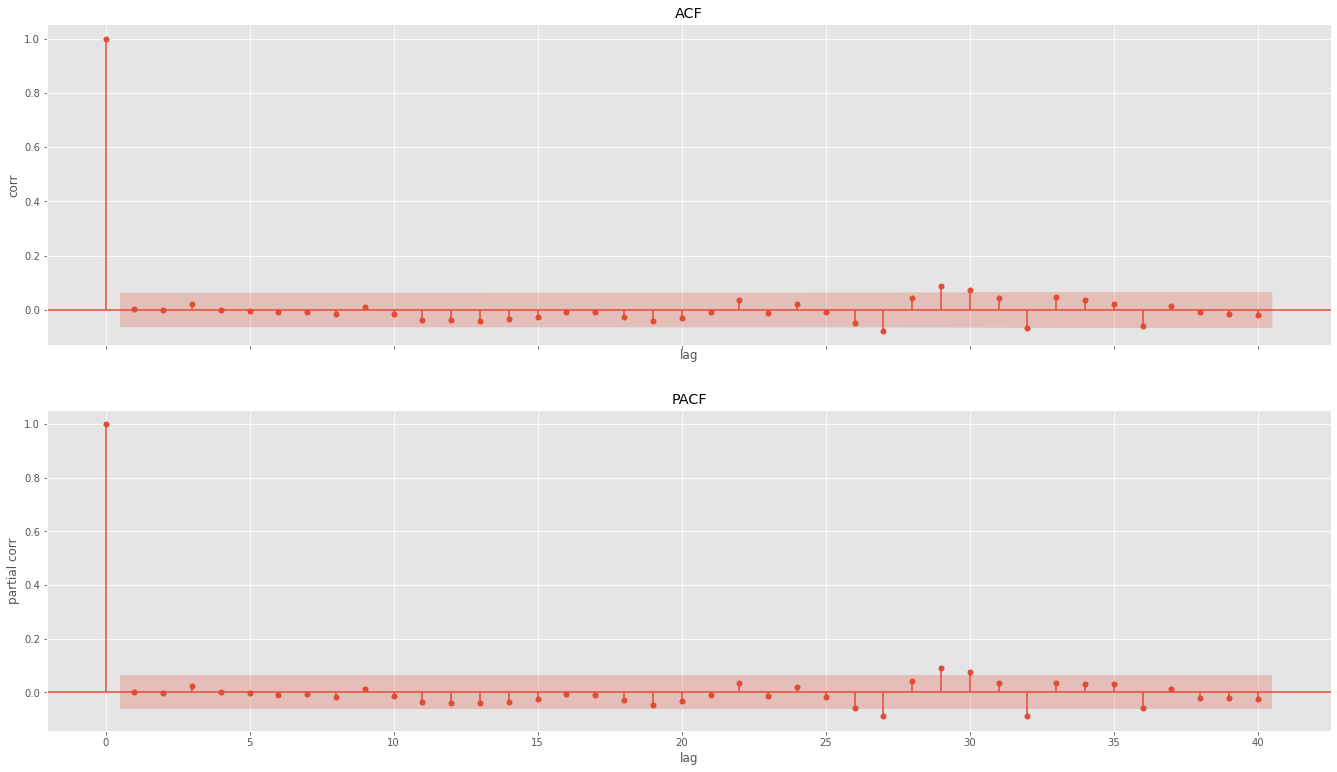

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(23, 13), sharex=True)
plot = plot_acf(resid_ets_overall, ax=ax[0], lags=40)
plot = plot_pacf(resid_ets_overall, ax=ax[1], lags=40)
ax[0].set(title='ACF', xlabel='lag', ylabel='corr')
ax[1].set(title='PACF', xlabel='lag', ylabel='partial corr')
plt.show()

Используем Ljung-Box test:

In [36]:
for m in [2, 5, 10, 20, 30]:
    lb_p = ljung_box(resid_ets_overall, m)
    conclusion = 'H0 rejected' if (lb_p<0.05) else 'H0 not rejected'
    if m == 2:
        output = f'Ljung-Box p-value (m={m}): {np.round(lb_p, 3)},\t' + conclusion
    else:
        output = f'                ↳ (m={m}): {np.round(lb_p, 3)},\t' + conclusion

    print(output)

Ljung-Box p-value (m=2): 1.0,	H0 not rejected
                ↳ (m=5): 1.0,	H0 not rejected
                ↳ (m=10): 1.0,	H0 not rejected
                ↳ (m=20): 0.371,	H0 not rejected
                ↳ (m=30): 0.0,	H0 rejected


##### Результаты (0.6 балла)

Постройте суммарный прогноз ETS-модели и модели остатков на тесте. Визуализируйте прогноз и тестовые значения на графике. Подсчитайте MAE прогноза. Добавьте на график прогноз модели из Блока 1. Какая из двух моделей получилась лучше? Как думаете, почему? Обе ли модели смогли пробить порог сезонной наивной модели?

In [37]:
ets_trend_seas_resid_fc = ets_trend_seas_fc + resid_ets_fc - 120

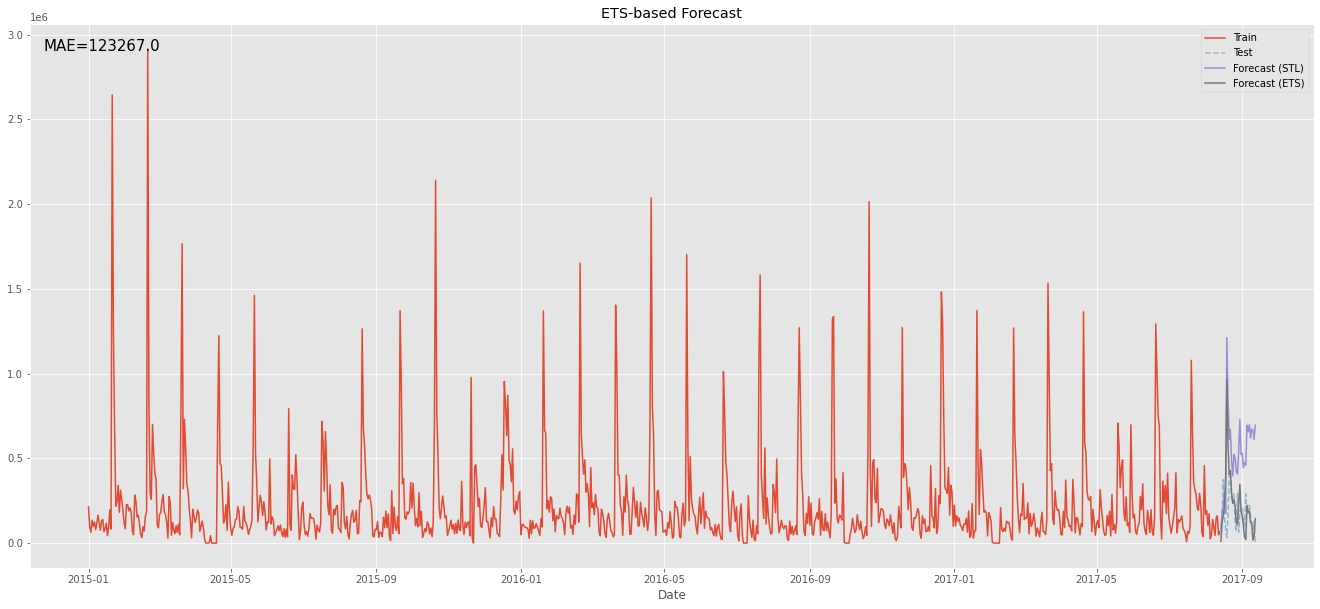

In [38]:
fig, ax = plt.subplots(1, figsize=(23, 10))

ax.plot(y_train - 120, label = 'Train')
ax.plot(y_test - 120, label = 'Test', alpha=.5, ls='--')
ax.plot(stl_trend_seas_resid_fc, label = 'Forecast (STL)')
ax.plot(ets_trend_seas_resid_fc, label = 'Forecast (ETS)')

curr_mae = np.round(mae(y_test - 120, ets_trend_seas_resid_fc))
ax.text(0.01, 0.95, f'MAE={curr_mae}', size=15, transform=ax.transAxes)

ax.set(title='ETS-based Forecast', xlabel='Date', ylabel='')
ax.legend()
plt.show()

Можно глянуть чуть поближе:

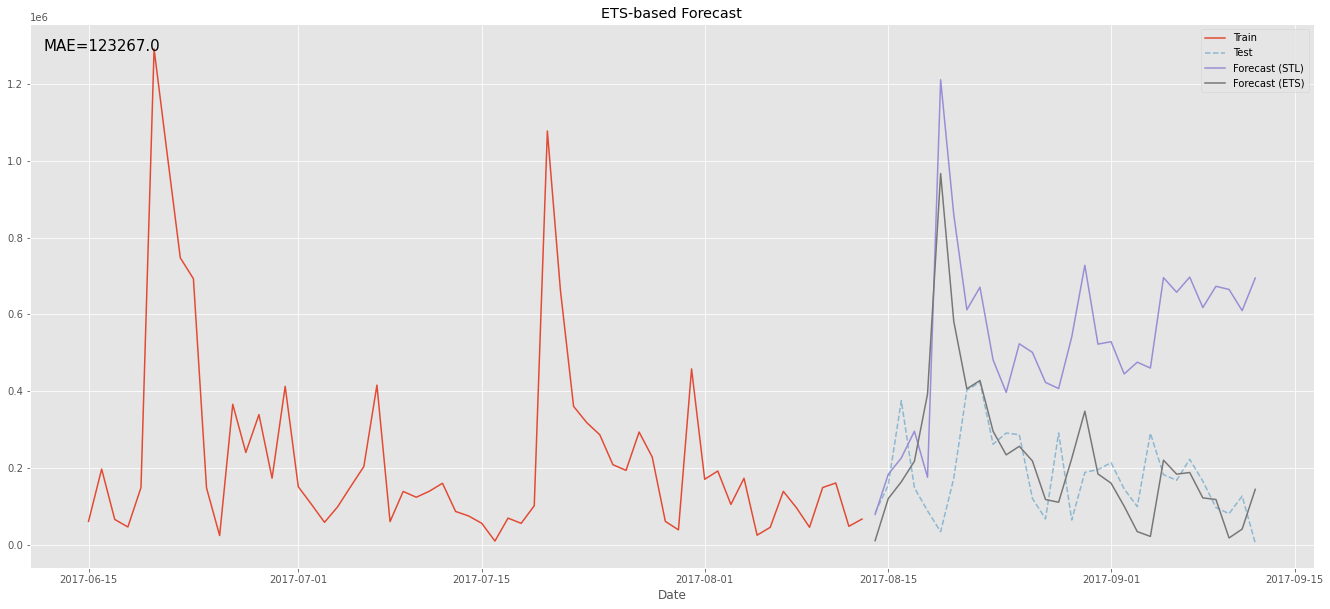

In [39]:
fig, ax = plt.subplots(1, figsize=(23, 10))

ax.plot((y_train - 120).tail(60), label = 'Train')
ax.plot((y_test - 120), label = 'Test', alpha=.5, ls='--')
ax.plot(stl_trend_seas_resid_fc, label = 'Forecast (STL)')
ax.plot(ets_trend_seas_resid_fc, label = 'Forecast (ETS)')

curr_mae = np.round(mae(y_test - 120, ets_trend_seas_resid_fc))
ax.text(0.01, 0.95, f'MAE={curr_mae}', size=15, transform=ax.transAxes)

ax.set(title='ETS-based Forecast', xlabel='Date', ylabel='')
ax.legend()
plt.show()

In [40]:
mae_naive = mae(y_test - 120, atm.shift(30).loc[y_test.index, :] - 120)
mae_naive = np.round(mae_naive)

print(f'MAE наивной модели: {mae_naive}')

MAE наивной модели: 147887.0


MAE наивной модели смогла пробить только модель, основанная на ETS. Скорее всего, это связано с тем фактом, что мы не особо аккуратно подходили к подбору моделей для предсказания отдельных компонент STL. В итоге получилось, что ETS  в силу отсутствия излишних приколов показала себя как надо.  

##### Скиньте мем (Бесценно)

In [41]:
# ༼ つ ◕_◕ ༽つ

##### Рубрика "как вам домашка?"

Поделитесь, что вам понравилось, а что нет. Это важно

- Делать меньше ошибок в формулировках. Например, индекс нужен был не PeriodIndex, а DatetimeIndex. Такое сильно бесит и заставляет тупить там, где вообще не нужно тупить.

- Проверять, что модели умеют делать прогнозы на трейне :)